## Examples of use of RDKit

In [58]:
from rdkit import Chem

### Generate a molecule from SMILES, generate 3D coordinates and visualize it

First, generate the molecule from SMILES. Example taken for Nirmatrelvir from [Drugbank](https://go.drugbank.com/drugs/DB16691). 

In [59]:
m = Chem.MolFromSmiles('[H][C@]12CN([C@H](C(=O)N[C@@H](C[C@]3([H])CCNC3=O)C#N)[C@@]1([H])C2(C)C)C(=O)[C@@H](NC(=O)C(F)(F)F)C(C)(C)C')
m.SetProp('_Name','Nirmatrelvir')
print(Chem.MolToMolBlock(m))

Nirmatrelvir
     RDKit          2D

 35 37  0  0  0  0  0  0  0  0999 V2000
   -0.4330   -0.7500    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.8596   -1.2135    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -2.7413    0.0000    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0
   -1.8596    1.2135    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -2.3231    2.6401    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -3.7903    2.9520    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   -1.3194    3.7548    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0
   -1.7830    5.1814    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.7793    6.2961    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.2428    7.7227    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -2.6694    8.1862    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -2.6694    9.6862    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.2428   10.1498    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0
   -0.3611   

Save now the molecule in PDB format and visualize both 2D and 3D images

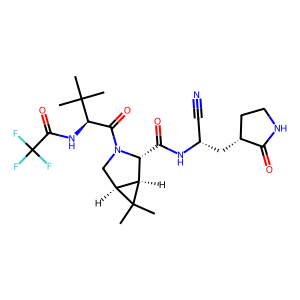

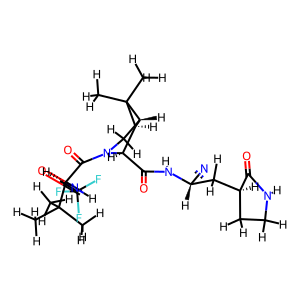

In [60]:
from rdkit.Chem import AllChem
from IPython.display import display, Image, SVG

m2 = Chem.AddHs(m)
AllChem.EmbedMolecule(m2)
Chem.MolToPDBFile(m2,'data/nirmatrelvir.pdb')
fig2D='images/nirmatrelvir2D.png'
fig3D='images/nirmatrelvir3D.png'
Chem.Draw.MolToFile(m,fig2D)
Chem.Draw.MolToFile(m2,fig3D)

display(Image(filename=fig2D))
display(Image(filename=fig3D))

### Find functional groups and display them in 2D

example on how to get substruture matches

In [61]:
mol = Chem.MolFromInchi("InChI=1S/C6H6O2/c1-5(7)6-3-2-4-8-6/h2-4H,1H3")
furan_smarts = "o1cccc1"
furan = Chem.MolFromSmarts(furan_smarts)
Chem.Mol.GetSubstructMatches(mol, furan, uniquify=True)

((7, 3, 1, 2, 5),)

Extract fragments / functional groups from the molecule by using the [RDKit implementation](https://github.com/rdkit/rdkit/blob/master/Contrib/IFG/ifg.py) of [Eartl's algorithm](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-017-0225-z).

In [93]:
import sys
import os
from rdkit import RDPaths

sys.path.insert(0, './utils/')

import ifg  #  implementation of Eartl search for Functional Groups
ifg_path = os.path.join(RDPaths.RDContribDir, 'IFG')
if os.path.exists(ifg_path):
    sys.path.append(ifg_path)

def map_fgs(mol):
    atoms = list(mol.GetAtoms())
    for atom in atoms:
        atom.SetProp("IFG_TYPE", "")
    fgs = ifg.identify_functional_groups(mol)
    for fg in fgs:
        for atmid in fg.atomIds:
            atom = mol.GetAtomWithIdx(atmid)
            atom.SetProp('IFG_TYPE', fg.type)
    return mol 

map_fgs(m)
res = set() 
for atom in m.GetAtoms(): 
    res.add(atom.GetProp('IFG_TYPE'))

print(res)



{'', 'CN(C)C(C)=O', 'CF', 'CC#N', 'CNC(C)=O', 'CC(=O)NC'}


Visualize now the different functional groups in the molecule. See [this stackoverflow Q/A](https://stackoverflow.com/questions/69735586/how-to-highlight-the-substructure-of-a-molecule-with-thick-red-lines-in-rdkit-as).

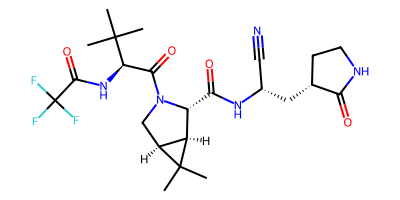

CN(C)C(C)=O


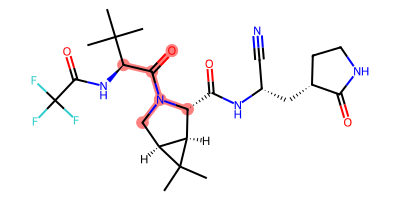

CF


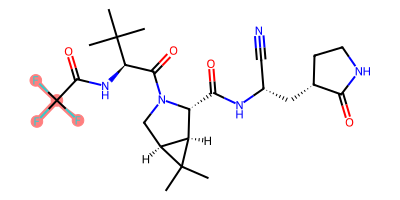

CC#N


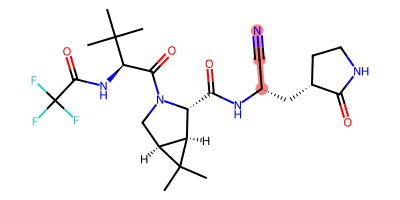

CNC(C)=O


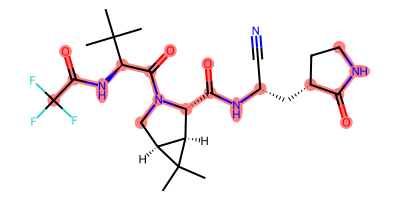

CC(=O)NC


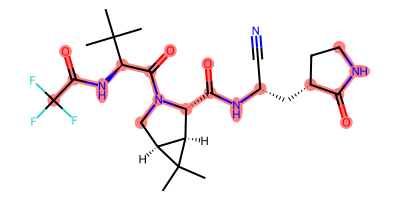

In [91]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
from copy import deepcopy


def increase_resolution(mol, substructure, size=(400, 200), kekulize=True):
    mol = deepcopy(mol)
    substructure = deepcopy(substructure)
    rdDepictor.Compute2DCoords(mol)
    if kekulize:
        Chem.Kekulize(mol)  # Localize the benzene ring bonds

    drawer = rdMolDraw2D.MolDraw2DSVG(size[0], size[1])

    # highlightAtoms expects only one tuple, not tuple of tuples. So it needs to be merged into a single tuple
    matches = sum(mol.GetSubstructMatches(substructure), ())
    drawer.DrawMolecule(mol, highlightAtoms=matches)

    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return svg.replace('svg:', '')


def save_svg(svg, filepath):
    """
    Save svg content in filepath

    :param str  svg:        SVG content
    :param str  filepath:   Path of the SVG file to save
    :return:
    """
    
    file_handle = open(filepath, 'w')
    file_handle.write(svg)
    file_handle.close()

for fg in res:
    patt = Chem.MolFromSmarts(fg)
    fig=increase_resolution(m, patt, kekulize=True)
    print(fg)
    display(SVG(fig))
    save_svg(fig,'images/frag'+fg+'.svg')


Collection of Functional Groups that come with RDKit

/home/jordivilla/miniconda3/envs/docking/share/RDKit/Data/FunctionalGroups.txt
methyl amide


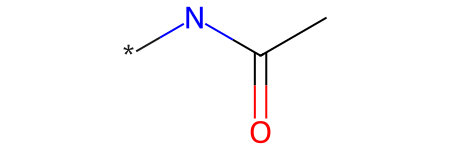

carboxylic acids


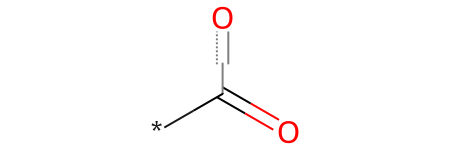

carbonyl methyl ester


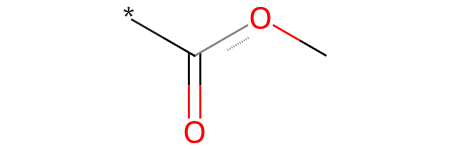

terminal aldehyde


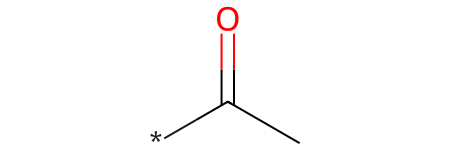

amide


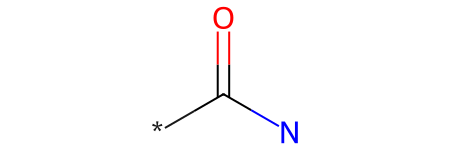

carbonyl methyl


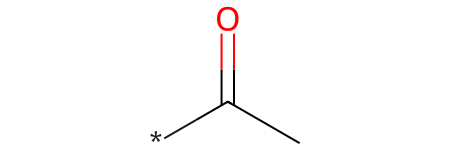

isocyanate


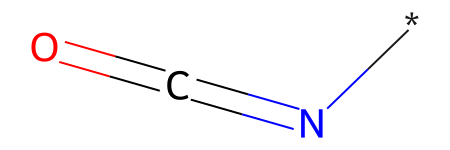

isothiocyanate


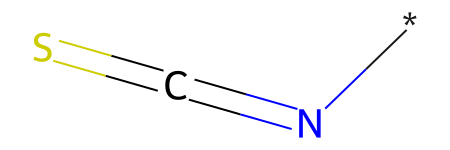

nitro


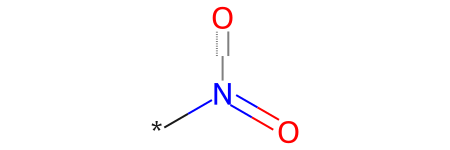

nitroso


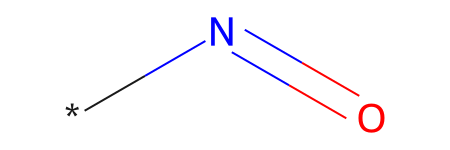

oximes


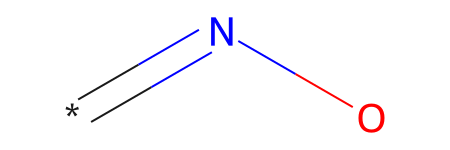

Imines


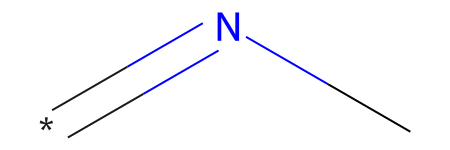

Imines


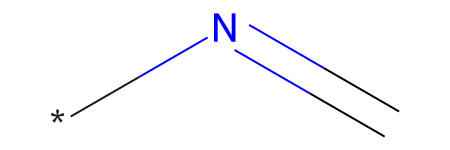

terminal azo


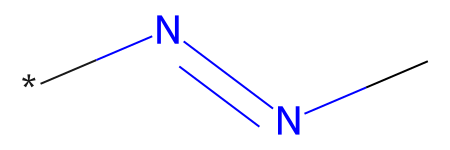

hydrazines


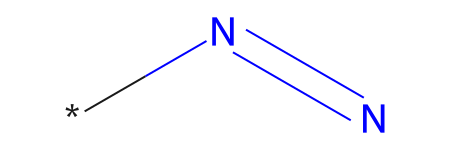

diazo


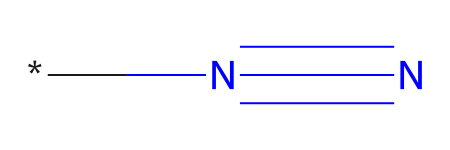

cyano


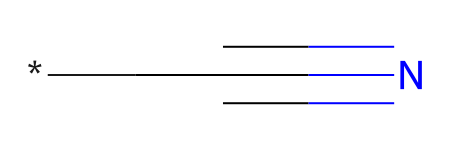

primary sulfonamide


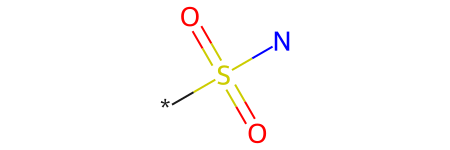

methyl sulfonamide


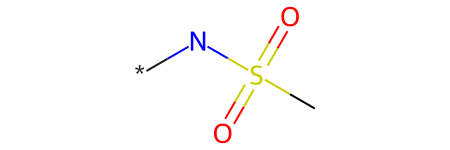

sulfonic acid


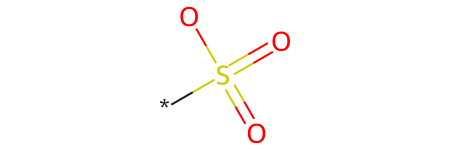

methyl ester sulfonyl


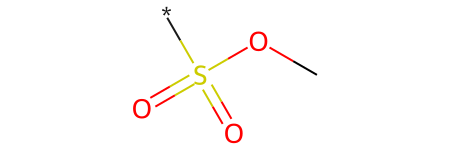

methyl sulfonyl


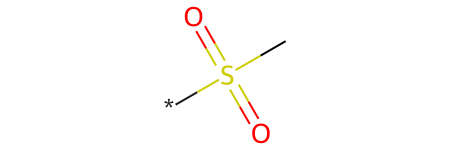

sulfonyl chloride


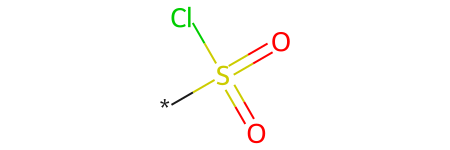

methyl sulfinyl


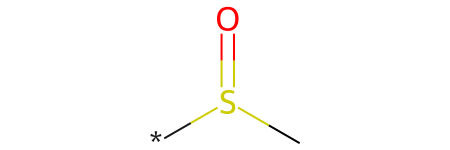

methylthio


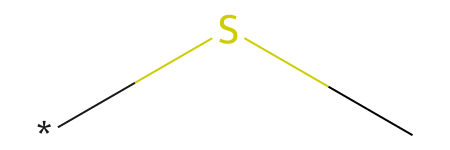

thiols


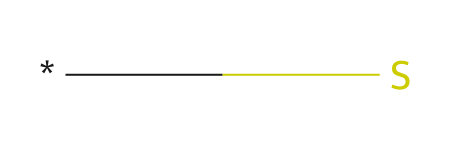

thiocarbonyls


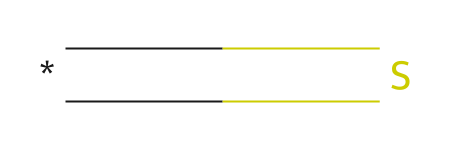

halogens


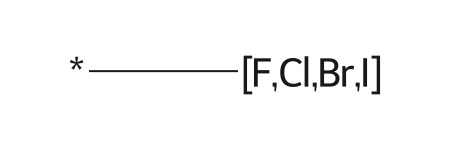

t-butyl


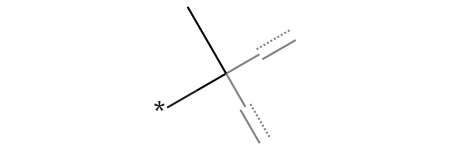

trifluoromethyl


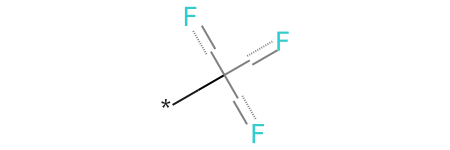

acetylenes


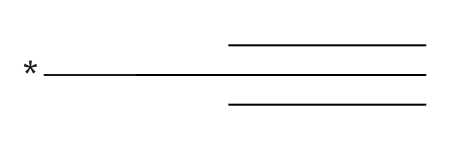

cyclopropyl


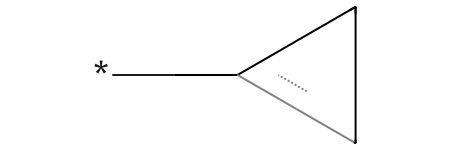

ethoxy


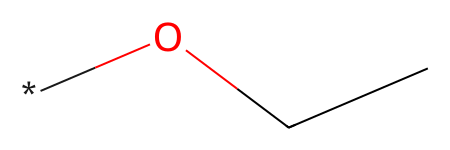

methoxy


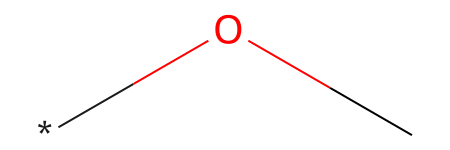

side-chain hydroxyls


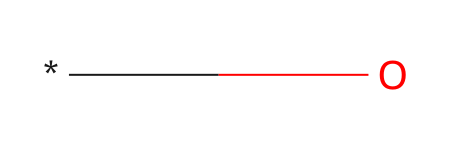

side-chain aldehydes or ketones


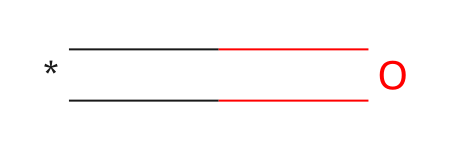

primary amines


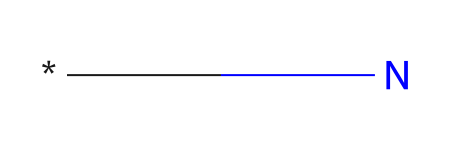

???


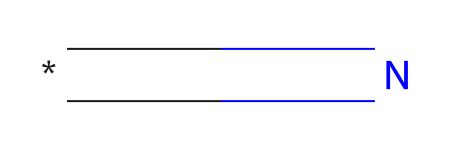

nitriles


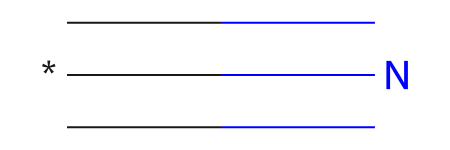

In [ ]:
import os
from rdkit.Chem import RDConfig
from rdkit.Chem import FunctionalGroups
fName = os.path.join(RDConfig.RDDataDir, 'FunctionalGroups.txt')
print(fName)
catparams =FunctionalGroups.BuildFuncGroupHierarchy(fileNm=fName)
for param in catparams:
    print(param.name)
    param.pattern.UpdatePropertyCache(strict=False)
    Chem.FastFindRings(param.pattern)
    Chem.SetHybridization(param.pattern)
    display(param.pattern)
